## PyPDF2 extraction
Simple text extraction from PDF

In [134]:
from PyPDF2 import PdfReader

def extract_text_from_pdf(pdf_file):
    pdf_reader = PdfReader(pdf_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

extract_text_from_pdf("inputs/invoices/2Modern.pdf")

'INVOICE\n* Please note our new remittance address effective 12/20/2022: 2Modern, PO Box 840603, Los Angeles, CA 90084-0603.\n* For credit card payments, please fill out the attached form and return / For check payment, please make checks out to 2Modern and\nremit to address above*\n* View our return policy at\xa0 . www.2modern.com/returns$3,571.36 Balance Due$3,571.37 Transaction Total$7,142.73 Total$0.00 Shipping and\nHandling$467.28 Tax$6,675.45 Total Price$1,481.55 Total Discount$8,157.00 Subtotal \xa0SM: Source / Diplomat Phase 2B / 24-DPA3-023\n/ FB-410 & 24-DPA3-023 / FB-441sidemark3715 SW 30th Ave\nFort Lauderdale, Florida 33312\nUnited StatesShip ToSorensen c/o The Advance Group Ship To Name\n921 SW Washington Street, Suite 518\nPortland, Oregon 97205\nUnited StatesBill ToHollywood FL Owner, LLC c/o Source Bill To NamePO#24-DPA3-023 Customer PO #pondi@2modern.com EmailDirect: 925.448.9105 PhonePondi Sottile Prepared By3/25/2025 Created DatePO#24-DPA3-023 Quote Name263048 Invoi

# SetUp
Install the dependencies you need to run the notebook

In [9]:
# !brew install poppler tesseract libmagic

## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [120]:
from unstructured.partition.auto import partition


filename = "inputs/invoices/2Modern.pdf"
elements = partition(filename=filename, content_type="application/pdf")
print("\n\n".join([str(el) for el in elements][:10]))

%6 2MODERN —_

Company Address 35 Miller Ave #192 Invoice 263048 Mill Valley, California 94941 Quote Name PO#24-DPA3-023 United States Created Date 3/25/2025 Submit Payment To: 2Modern PO Box 840603 Los Angeles, CA 90084-0603 Prepared By Pondi Sottile Phone Direct: 925.448.9105 Email pondi@2modern.com Customer PO # PO#24-DPA3-023 Ship To Name Sorensen c/o The Advance Group Bill To Name Hollywood FL Owner, LLC c/o Source Ship To 3715 SW 30th Ave Bill To 921 SW Washington Street, Suite 518 Fort Lauderdale, Florida 33312 Portland, Oregon 97205 United States United States sidemark SM: Source / Diplomat Phase 2B / 24-DPA3-023

/ FB-410 & 24-DPA3-023 / FB-441

Sales Discount Total (Percentage) Price

Product Option/Col tit roduct ption/Color Price Quantity

TAG: FB-410 / Small PI Console Table PI Console Table - Default Title (Small / $999.00 3.00 15.00% | $2,547.45 Mahogany Dark Brown

Castle LED Wall Sconce OTS TAG: FB-441 $2,580.00} 2.00 20.00% | $4,128.00 Smoke / Black / 2 Lights

Specia

## From the Multimodal RAG strategy
partition the pdf into chunks, and set a chunking strategy  
the character chunking strategy is helpful for long documents that may need to be split for RAG retrieval,  
or to target specific areas of the document for analysis  
studies suggest effective chunking at 512 tokens with 25% chunk overlap  
look into chunking strategy, and how to not split elements in the middle (tables, etc)  

In [121]:
from unstructured.partition.pdf import partition_pdf

input_path = "inputs/invoices/"
file_path = input_path + '2Modern.pdf'
image_output_dir_path = 'outputs/images/'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    skip_infer_table_types=False,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image", "Table"],   # Add 'Table' to list to extract image of tables
    image_output_dir_path=image_output_dir_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)

### Display information about the elements within the first chunk

In [122]:
chunks[0].metadata.orig_elements

### Deeper look at what makes up the chunk

In [123]:
chunks[0].to_dict()

{'type': 'CompositeElement',
 'element_id': '2e2c3cdefddf45858264b6e66163f251',
 'text': '%6 2MODERN\n\n—_\n\nCompany Address 35 Miller Ave #192\n\nMill Valley, California 94941 United States\n\nInvoice 263048 Quote Name PO#24-DPA3-023 Created Date 3/25/2025\n\nSubmit Payment\n\nTo: 2Modern PO Box 840603 Los Angeles, CA 90084-0603\n\nPrepared By\n\nPondi Sottile\n\nPhone\n\nDirect: 925.448.9105\n\nEmail\n\npondi@2modern.com\n\nCustomer PO # PO#24-DPA3-023\n\nShip To Name\n\nSorensen c/o The Advance Group\n\nBill To Name\n\nBill To\n\nHollywood FL Owner, LLC c/o Source\n\n921 SW Washington Street, Suite 518 Portland, Oregon 97205 United States\n\nShip To\n\n3715 SW 30th Ave Fort Lauderdale, Florida 33312 United States\n\nsidemark SM: Source / Diplomat Phase 2B / 24-DPA3-023 / FB-410 & 24-DPA3-023 / FB-441\n\nSales Discount Total (Percentage) Price Product Option/Col tit roduct ption/Color Price Quantity TAG: FB-410 / Small PI Console Table PI Console Table - Default Title (Small / $999.

In [88]:
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

## Partitioning
split the pdf into elements  
https://docs.unstructured.io/open-source/core-functionality/partitioning#partition-pdf

In [145]:
from unstructured.partition.auto import partition

fname = "inputs/invoices/2Modern.pdf"

elements = partition(filename=fname,
                         strategy='hi_res',
                         infer_table_structure=True,  # return tables as html in metadata
                         extract_images_in_pdf=True,  # extract images to base64
                         extract_image_block_types=["Image", "Table"],  # extract images and tables
                         extract_image_block_output_dir=image_output_dir_path,  # folder to extract images to
                         extract_image_block_to_payload=True, # extract images to base64 to include in payload for LLM
                        #  skip_infer_table_types=False, -- deprecated?
           )

tables = [el for el in elements if el.category == "Table"]
images = [el for el in elements if el.category == "Image"]

print(elements)

element_counts = {}

# get counts of each type of element in the array
for el in elements:
    category = el.category
    if category in element_counts:
        element_counts[category] += 1
    else:
        element_counts[category] = 1

for el in element_counts:
    print(el, element_counts[el])

# select only the Table Elements
type_to_print = "Table"

for el in elements:
    if el.category == type_to_print:
        print(el.to_dict())

[<unstructured.documents.elements.Title object at 0x17f2039a0>, <unstructured.documents.elements.Header object at 0x17f203e00>, <unstructured.documents.elements.Title object at 0x17f203d20>, <unstructured.documents.elements.Address object at 0x17f203770>, <unstructured.documents.elements.Table object at 0x17f203af0>, <unstructured.documents.elements.Title object at 0x17f203e70>, <unstructured.documents.elements.NarrativeText object at 0x17f203460>, <unstructured.documents.elements.Title object at 0x17f2037e0>, <unstructured.documents.elements.Title object at 0x17f203f50>, <unstructured.documents.elements.Title object at 0x17f203a80>, <unstructured.documents.elements.Text object at 0x17f203ee0>, <unstructured.documents.elements.Title object at 0x17f203310>, <unstructured.documents.elements.EmailAddress object at 0x17f203cb0>, <unstructured.documents.elements.Title object at 0x17f203bd0>, <unstructured.documents.elements.Title object at 0x17f203a10>, <unstructured.documents.elements.Titl

## Display Images Saved from Tables

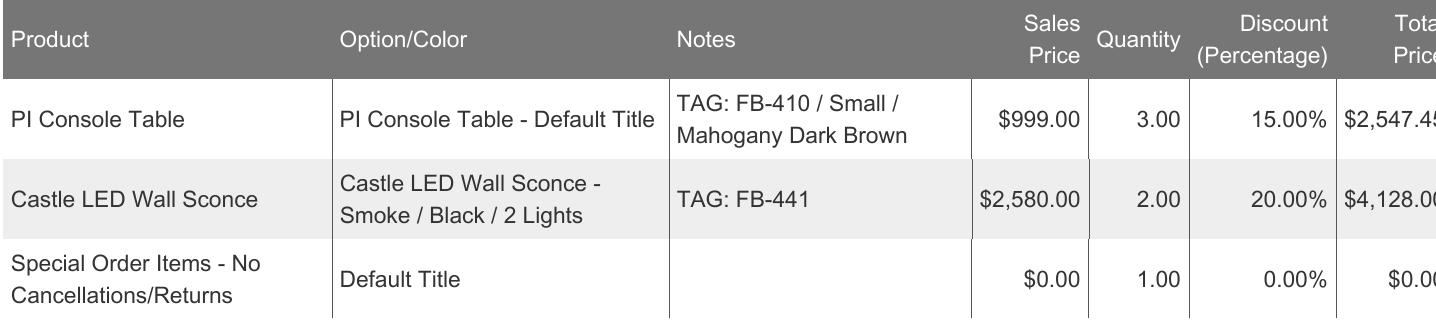

In [136]:
import base64 
from IPython.display import Image, display, IFrame, HTML

def display_base64_image(base64_image):
    image_data = base64.b64decode(base64_image)
    image = Image(data=image_data)
    display(image)

display_base64_image(tables[1].metadata.image_base64)

## Display PDF with Overlays


this is the width (np.float64(503.7532653808594), np.float64(85.1102294921875))
this is the scaled 181.35117553710936
[{'category': 'Table', 'rect': (np.float64(35.941322021484375), np.float64(14.690706481933594)), 'text': '%6 2MODERN'}]


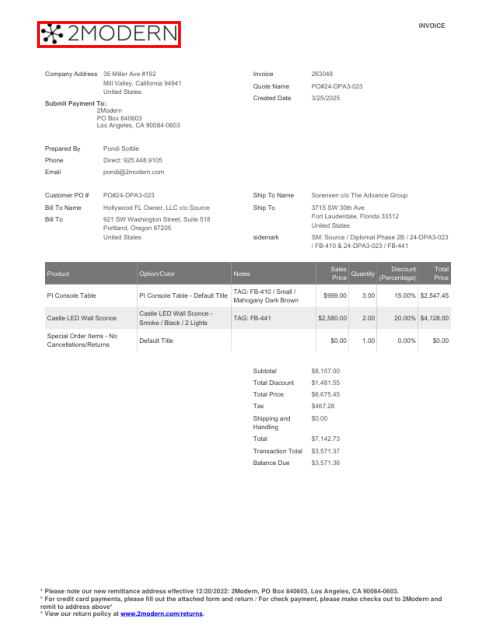

In [191]:
import fitz  # PyMuPDF
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Open the PDF file
pdf_document = file_path
doc = fitz.open(pdf_document)

# Select the page
page_number = 0  # Change to the page number you want
page = doc.load_page(page_number)

# Render page to an image
pix = page.get_pixmap()
img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
scale = pix.width/1700

def get_width_height(coordinates):
    """
    Calculate the width and height from a tuple containing four tuples of (x, y) coordinates.

    Parameters:
    coordinates (tuple): A tuple containing four tuples of (x, y) coordinates.

    Returns:
    tuple: A tuple containing the width and height.
    """
    # Unpack the coordinates
    (x1, y1), (x2, y2), (x3, y3), (x4, y4) = coordinates

    # Calculate the width and height
    min_x = min(x1, x2, x3, x4)
    max_x = max(x1, x2, x3, x4)
    min_y = min(y1, y2, y3, y4)
    max_y = max(y1, y2, y3, y4)

    width = max_x - min_x
    height = max_y - min_y

    return width, height

first_element = elements[0]
first_wh = get_width_height(first_element.metadata.coordinates.points)
print("this is the width", first_wh)
print("this is the scaled", first_wh[0]*scale )
first_coord = first_element.metadata.coordinates.points[0]
test_element = [{"category": "Table", "rect": (first_coord[0]*scale, first_coord[1]*scale), "text": first_element.text}]
print(test_element)

transformed_elements = []

# Plot the image
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

# Plot bounding boxes
for el in test_element:  # Use transformed_elements instead of elements
    bbox = el["rect"]
    rect = patches.Rectangle(
        (bbox), first_wh[0]*scale, first_wh[1]*scale,
        linewidth=2, edgecolor='r', facecolor='none'
    )
    ax.add_patch(rect)

plt.axis('off')
plt.show()